Follow up from previously acquired data: /workspace/projects/TES/data/20170316_SQUID1_bandwidth_characterisation
We found that under the conditions 155 mK, Ibias = 300 uA, GBWP = Max, Rf = 100 kOhm, Input Flux Termination @ FLL = Unknown, FLL mode, we had a bandwidth of 1.7 MHz, that explained the ~170 ns pulse rise time.
Antia reported ~25 ns rise time with open loop amplifiers.
However, Rf to 30 kOhm resulted in too low SNR.

We would like to investigate the source of noise in the system, with the hope of running our amplifiers with a lower Rf, thereby increasing the bandwidth, reducing the rise time.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%matplotlib inline

## SQUID Noise Measurement
To measure the noise contribution from the SQUID:

Driving the TES to 

* conducting state (iBias=125uA) decouples the TES from the SQUID input(Jan Dreyling-Eschweiler p.96).  - arguable since the impedance change will only be 50%...
    
* speculative reasons why superconducting state (iBias=0uA) should minimize noise input to SQUID:
    * the impedance matching between the TES and Lin is expected to be maximum only when R_TES = R_conducting/2. However, this is suspect since there is no reason to assume Magnicon input coils are have |reactances| equal to R_conducting/2 to within a factor of 100%.
    
    * no supply current noise.
    
    * only source is Johnson noise of shunt at 20mOhm, 80mK, i=0 < typical iBias, and parasitic load resistance in series with TES.
    
    * R is constant and does not approach 0 from IV curve gradient - this corresponds to parasitic resistance. If R = 0 then it is unknown if iTES_noise could increase since it presents a smaller load to the Johnson noise of R_shunt.

To verify that we have minimal current in the system, we sketch the iTES vTesBias curve (IV), next Section.

In [22]:
SupCond_Noise = np.loadtxt('./superconducting_vs_conducting_noise_spectrums/0uArbw30khzvbw300khz10avg.txt', skiprows=46)
Cond_Noise = np.loadtxt('./superconducting_vs_conducting_noise_spectrums/125uArbw30khzvbw300khz10avg.txt', skiprows=46)

In [23]:
def convert_units(unit):
    """invert dBm equation to current through 50 Ohm R&S"""
    def new_spectrum(spectrum):
        def wrapper(noise_array):
            r = 50 #ohms
            bins, power_dbm = spectrum(noise_array)
            power = 1e-3*10**(power_dbm/10)
            if unit == 'amps':
                return bins, np.sqrt(power/r)
            if unit == 'volts':
                return bins, np.sqrt(power*r)
            if unit == 'watts':
                return bins, power
        return wrapper
    return new_spectrum

def spectral_density(spectrum):
    """convert spectrum into spectral density"""
    def wrapper(noise_array):
        bins, data = spectrum(noise_array)
        bin_size = bins[1]-bins[0]
        return bins, data/bin_size
    return wrapper
    
def iTES_from_vOut():
    """converts voltage output """
    pass

@spectral_density
@convert_units('watts')
def spectrum(noise_array):
    """returns the noise density in Watts(default)"""
    bins = noise_array[:,0]
    power_dbm = noise_array[:,1]
    return np.array(bins), np.array(power_dbm)

def f3dB(noise_array, plot=False, color='blue'):
    """finds and plots 3dB-cuttoff frequency"""
    def quick_hor(value,label,color):
        """plots horizontal level"""
        plt.axhline(value,label=label,linestyle='--',color=color)
    def quick_vert(value,label,color):
        """plots vertical level"""
        plt.axvline(value,label=label,linestyle='--',color=color)
        
    bins, density = spectrum(noise_array)
    mask=(bins>1e5)&(bins<0.8e6)
    max_density = np.max(density[mask])

    median_density = np.median(density[mask]) #estimates the density before 3dB falloff
    
    def find_idx(array,value):
        """finds index of array closest to value"""
        return np.argmin(np.abs(array-value))
    density_at_f3dB = median_density/2
    
    f3dB = bins[find_idx(density[:np.argmin(density)],density_at_f3dB)]
    if plot:
        quick_vert(f3dB, 'f3dB',color)
        quick_hor(median_density, 'median', color)
        quick_hor(density_at_f3dB, '3dB',color)
    return f3dB/1e6

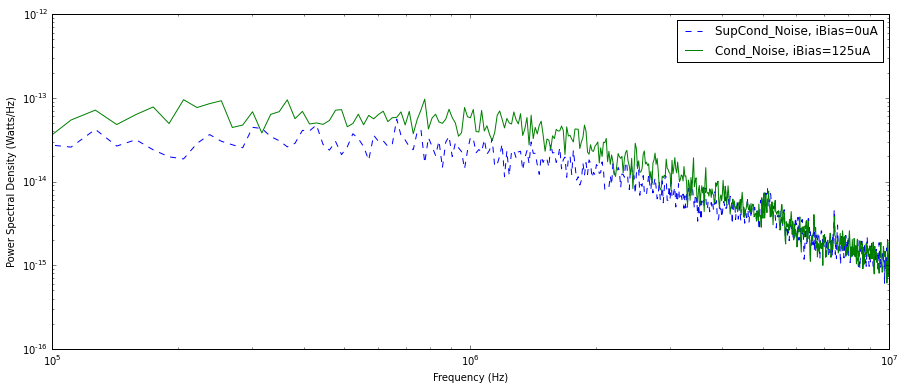

In [24]:
plt.figure(figsize=(15,6))
plt.plot(*spectrum(SupCond_Noise), label='SupCond_Noise, iBias=0uA',linestyle='--')
plt.plot(*spectrum(Cond_Noise), label='Cond_Noise, iBias=125uA')
# print(f3dB(SupCond_Noise,plot=True,color='black'))
# print(f3dB(Cond_Noise,plot=True,color='blue'))
plt.semilogx()
plt.semilogy()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (Watts/Hz)')
plt.ylim(1e-16,1e-12)
plt.xlim(100e3,1e7) #R&S FSH8 only operates 100kHz onwards
plt.legend()
plt.tight_layout
plt.savefig('superconducting_vs_conducting_noise.pdf')
plt.show()

## IV Curve of SQUID 1
IV Curves are included to prove that 

* iBias = 125uA is sufficient to drive the TES conducting.

In [25]:
folder = './20170324_SQUID1_bandwidth_characterisation/'
time = np.loadtxt(folder+'C1_monitor_00000.txt',skiprows=5, delimiter=',')[:,0]
monitor = np.loadtxt(folder+'C1_monitor_00000.txt',skiprows=5, delimiter=',')[:,1]
vOut = np.loadtxt(folder+'C2_SQ1_00000.txt',skiprows=5, delimiter=',')[:,1]
iBias = monitor*250

## I, V, vs time

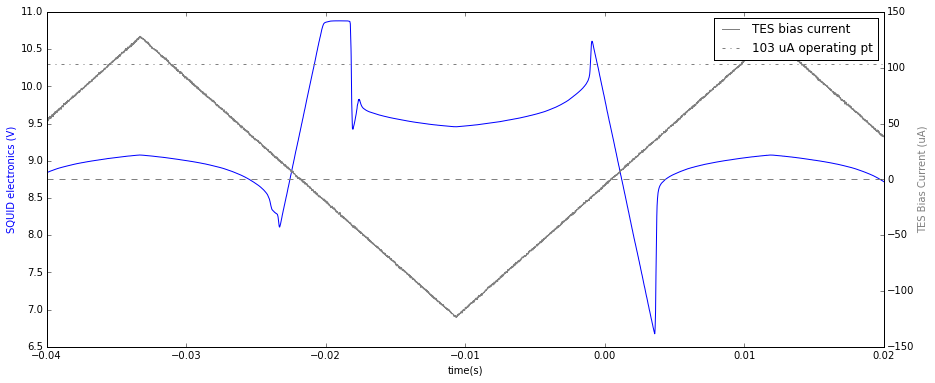

In [26]:
f, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(time, vOut,color='blue',label='SQUID electronics')
ax2 = ax1.twinx()
ax2.plot(time, iBias,color='grey',label='TES bias current')
ax2.axhline(0,linestyle='--',color='grey')
ax1.set_xlim(-0.04,0.02)
ax2.set_ylabel('TES Bias Current (uA)',color='grey')
ax1.set_ylabel('SQUID electronics (V)',color='blue')
ax1.set_xlabel('time(s)')
ax2.axhline(103,linestyle='-.',color='grey',label='103 uA operating pt')
ax2.legend()
plt.savefig('IV_time.pdf')

## IV Curve

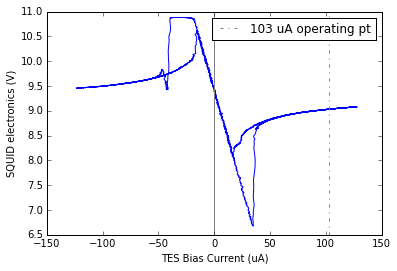

In [27]:
plt.figure()
mask = (time>-0.04)&(time<0.02)
plt.plot(iBias[mask],vOut[mask])
plt.xlabel('TES Bias Current (uA)')
plt.ylabel('SQUID electronics (V)')
plt.axvline(103,linestyle='-.',color='grey',label='103 uA operating pt')
plt.axvline(0,linestyle='-',color='grey')
plt.legend()
plt.savefig('IV_Curve.pdf')

TES actually exeriences higher current when iBias = 0uA compared to 103uA. Weird!
Lindeman Thesis p.159 shows that supercond and cond portions of the curve intersect, but we do not see that here.

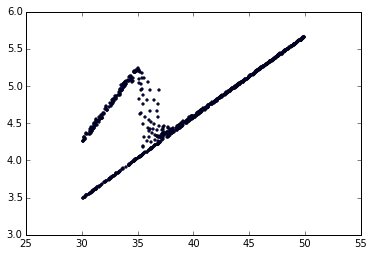

In [28]:
plt.figure()
mask = (iBias>30)&(iBias<50)
R = iBias[mask]/vOut[mask]
plt.scatter(iBias[mask],R,marker='.')

## Bandwidth Comparison of TES 5, SQUID 1, with different feedback resistances
Second, we send a nominal operating current 103 uA, which was verified to have a good SNR.
    Then, we change the gain of the system by adjusting Rf, keeping the GBP constant. This should increase the bandwidth and the noise. 
    We verify if the bw increased by comparing the f-3db cutoff frequency.

### Parameters

TES bias = 104 uA, T = 80 mK corresponding to good single photon signal to noise ratio.
Input Flux Termination @ FLL = OFF
SQUID Gain = Positive

We expect to see an effect on the BW - bandiwdth by changing Rf - feedback resister or/and GBP - gain bandwidth product.

Normal operation: Rf=100kOhm, GBP=7.2GHz.

Thermal runaway at: Rf=30kOhm, GBP=7.2GHz.

Other investigated operating point: Rf=23.1kOhm, GBP=2.25GHz.

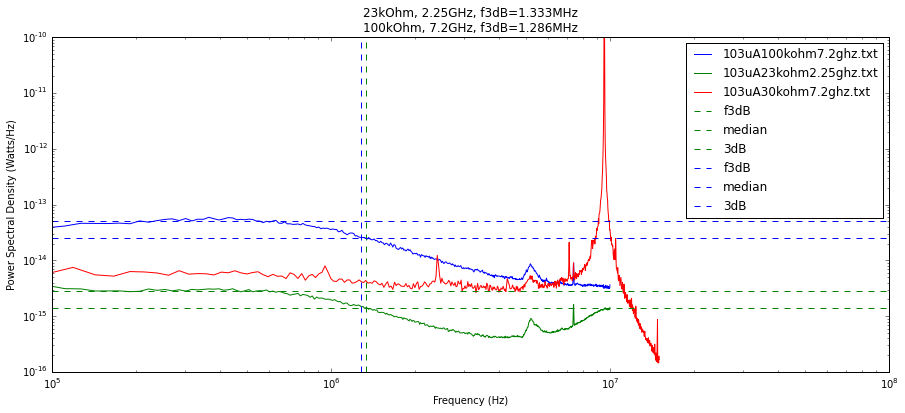

In [39]:
import glob
folder = './various_RFeedback_vs_GBP_ratios_noise_spectrums_IBias_104uA_80mK/'
plt.figure('Various Rf vs GBP')
plt.figure(figsize=(15,6))
for trace in glob.glob(folder+'*.txt'):
    plt.plot(*spectrum(np.loadtxt(trace,skiprows=46)),
        label=trace.split('/')[-1])
plt.title('23kOhm, 2.25GHz, f3dB={:.3f}MHz'.format(f3dB(np.loadtxt(folder+'103uA23kohm2.25ghz.txt',skiprows=46),plot=True,color='green'))+\
         '\n100kOhm, 7.2GHz, f3dB={:.3f}MHz'.format(f3dB(np.loadtxt(folder+'103uA100kohm7.2ghz.txt',skiprows=46),plot=True,color='blue')))

plt.semilogx()
plt.semilogy()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (Watts/Hz)')
plt.ylim(1e-16,1e-10)
plt.xlim(100e3,) #R&S FSH8 only operates 100kHz onwards
plt.legend()
plt.tight_layout
plt.savefig('Various_Rf_vs_GBP.pdf')
# plt.ylim(0.5e-15,8e-14)
# plt.xlim(0.5e6,5e6)
# plt.savefig('Various_Rf_vs_GBP_zoomed.pdf')

We observe that the f3dB ratios are approximately 4% different.
Whereas the Rf/GBP ratio is expected to be 25% different.

## Noise contribution from iBIAS source

To be measured: Drive the TES to superconducting state with iBIAS > 0:
    
* so that iBias is not shunted away.
    
* use IV curve to determine R_TES, and predict Johnson noise from R_TES, R_shunt. These are subtracted from measured noise spectrum to determine iBias noise.